In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import glob
import time
import scipy.stats
import seaborn as sns

import matplotlib.patches as patches

from astropy.table import Table, join
from multiprocessing import Process, Queue


sns.set()

### Introduction
This notebook goes through how to reproduce the plots in [this](https://arxiv.org/pdf/1807.11873.pdf) paper by Sáchez and Bernstein. The paper uses a Hierarchical Bayesian framework to estimate photometric redshifts. 

(write more later)

#### Set up global variables:

In [4]:
N = 100000 ## number of galaxies in each sample
nz = 50 ## number of redshift bins
nt = 50 ## number of type bins
nx = 1024 ## number of pixels in each dimension of density field
a = 1.5 ## model parameter for type distribution (see Eq. 34)
t0 = 0.3 ## model parameter for type distribution (see Eq. 34)
sig_F = 0.02 ## scale for feature likelihood
seed = 11
rng = np.random.RandomState(seed)

#### Define functions we'll be using throughout the notebook:

In [5]:
def setup_bins(nz, nt):
    
    '''
    Parameters:
    -----------
    
    nz: Number of redshift bins.
    
    nt: Number of type bins.
    
    Returns:
    --------
    
    z_bins: np.array() containing the redshift bin edges.
    
    z_mdpt: np.array() containing the redshift bin centers.
    
    t_bins: np.array() containing the type bin edges.
    
    t_mdpt: np.array() containing the type bin centers.
    
    '''
    
    z_bins = np.linspace(0, 1, nz+1)
    z_mdpt = (z_bins[1:] + z_bins[:-1]) / 2
    t_bins = np.linspace(0, 1, nt+1)
    t_mdpt = (t_bins[1:] + t_bins[:-1]) / 2
    
    return(z_bins, z_mdpt, t_bins, t_mdpt)

## Inverse transform sample
def sample(uniform, x_interp, size, rng):
    
    '''
    Parameters:
    -----------
    
    uniform:  Array of values sampled from a uniform distribution between [0,1] 
              over which the x_interp is interpolated over.
              
    x_interp: The domain of the CDF that has been interpolated over uniform.
    
    size:     Number of samples to be drawn.
    
    rng:      Instance of np.random.RandomState().
    
    Returns:
    --------
    
    Sampled values over the domain. 
    
    '''
    
    ## uniform is proxy for the CDF
    rndm = rng.uniform(size=size)
    idx = [(np.abs(uniform - rndm[ii])).argmin() for ii in range(size)]
    return(x_interp[idx])


## Type distribution
def prob_type(t, a, t0):
    
    '''
    Distribution for galaxy of type t.
    
    Parameters:
    -----------
    t : int or array
        Galaxy type(s) to be sampled.
    a : Model parameter.
    t0 : Model parameter.
    
    Returns:
    --------
    int or array
    
    Distribution of probabilities.
    '''
    
    num = t ** a
    den = np.exp(t / t0) ** a
    
    p = num / den
    norm = np.sum(p)
    
    return(p / norm)


def interpolate_type_cdf_domain(t_mdpt, t_bins, a, t0, N, rng):
    
    '''
    Parameters:
    -----------
    
    t_mdpt: np.array() containing the type bin centers.
    
    t_bins: np.array() containing the type bin edges.
    
    a : Model parameter.
    
    t0: Model parameter.
    
    N: Number of desired galaxies in the sample.
    
    rng: Instance of np.random.RandomState()
    
    Returns:
    --------
    
    uniform:  Array of values sampled from a uniform distribution between [0,1] 
              over which the x_interp is interpolated over.
              
    x_interp: The domain of the CDF that has been interpolated over uniform.
    
    '''
    
    p = prob_type(t_mdpt, a, t0)
    P = np.zeros_like(t_bins)
    P[1:] = np.cumsum(p)
    P /= P[-1] 
    
    u = rng.uniform(size=N)
    x_interp = np.interp(u, P, t_bins)
    return(u, x_interp)


## Redshift distribution
def assign_redshifts(t, rng):
    '''Generate a redshift distribution for 
    galaxies based on their type t.
    
    Parameters:
    -----------
    t : int or array
        Galaxy type(s) to be sampled.
    
    Returns:
    --------
    int or array
    Distribution of probabilities.
    '''
    
    n = len(t)
    z = np.ones_like(t)
    
    rnd = rng.uniform(size=n)
    
    for ii, tt in enumerate(t):
        if tt == 0:
            if rnd[ii] >= 0.2:
                z[ii] = tt
            else:
                z[ii] = tt + 0.02
        if tt == 1:
            if rnd[ii] >= 0.2:
                z[ii] = tt
            else:
                z[ii] = tt - 0.02
        else:
            if rnd[ii] >= 0.4:
                z[ii] = tt
            if tt < 0.02:
                z[ii] = tt + 0.02
            elif tt > 0.98:
                z[ii] = tt - 0.02
            else:
                if (rnd[ii] >= 0.2) and (rnd[ii] < 0.4):
                    z[ii] = tt + 0.02
                else:
                    z[ii] = tt - 0.02   
    return(z)

## Feature distribution
def feature_likelihood(t, scale, rng):
    
    '''Sample a feature value for each galaxy from a normal 
    distribution centered on the galaxy's type.
    
    Parameters:
    -----------
    
    t:     An array of type values 
    scale: The standard deviation of the flux distribution.
    rng:   Instance of np.random.RandomState()
    
    Returns:
    --------
    
    Feature values for each galaxy in the sample. 
    
    '''
    return(scipy.stats.norm.rvs(loc=t, scale=scale, random_state=rng))

## Delta field
def fftIndgen(n):
    
    '''Generate grid of k values over which to calculate 
       power spectrum.
    
    Parameters:
    -----------
    
    n: Dimension of delta field.
    
    Returns:
    --------
    
    Grid of k values from -(n/2 +1) to n/2 over which to calculate the power spectrum.
    
    '''
    a = range(0, int(n/2)+1)
    b = range(1, int(n/2))
    b = reversed(b)
    a = [i for i in a]
    b = [-i for i in b]
    return a + b

def gaussian_random_field(Pk = lambda k : k**-3.0, size = 1024):

    '''
    Generate a Gaussian random field.
    
    Parameters:
    -----------
    
    Pk: Function to compute the power spectrum.
    
    size: Dimension of delta field. 
    
    Returns:
    --------
    
    Amplitude of delta field in position (ra, dec) space. 
    '''

    def Pk2(kx, ky):
        
        '''
        Compute the 2-dimensional power spectrum.
        
        Parameters:
        -----------
        
        kx: x-dimension of the grid. 
        ky: y-dimension of the grid.
        
        Returns:
        --------
        
        The amplitude of the 2-d power spectrum at each point in the grid. 
        '''
        if kx == 0 and ky == 0:
            return 0.0
        return np.sqrt(Pk(np.sqrt(kx**2 + ky**2)))
    noise = np.fft.fft2(np.random.normal(size = (size, size)))
    amplitude = np.zeros((size,size))
    for i, kx in enumerate(fftIndgen(size)):
        for j, ky in enumerate(fftIndgen(size)):            
            amplitude[i, j] = Pk2(kx, ky)
    return np.fft.ifft2(noise * amplitude)

def delta_field(nx, nz, rms=2.5):
    
    '''
    Generate a Gaussian random field for each redshift slice. 
    
    Parameters:
    -----------
    
    nx: Number of pixels in x-direction of delta field (ra).
    nz: Number of pixels in y-direction of delta field (dec).
    rms: Variance of GRF.
    
    Returns:
    --------
    
    An array of shape (nx, nx, nz) containing the density of 
    galaxies in each redshift slice. 
    '''
    delta = np.empty((nx,nx,nz))
    for i in range(nz):
        z_slice = gaussian_random_field(Pk = lambda k: k**-3.0, size=nx).real
        ## set variance = 2.5
        delta[:,:,i] = (z_slice / np.std(z_slice)) * rms
    return(delta)

def get_positions(rho, z_indices, nx, nz, N, rng):
    
    '''
    Get (ra,dec) position for each galaxy.
    
    Parameters:
    -----------
    
    rho: The over-density field (as defined in Eq. 33)
    
    z_indices: The redshift bin that a galaxy falls into. 
    
    nx: 
    
    nz: 
    
    N:
    
    rng:
    
    Returns:
    --------
    
    Ra,Dec positions for each galaxy.
    
    '''
    
    rho_flat = rho.reshape(nx*nx, 50)
    cdf = np.cumsum(rho_flat, axis=0)
    cdf /= cdf[-1,:]

    unique, counts = np.unique(z_indices, return_counts=True)
    
    theta_x = np.empty(N, dtype=int)
    theta_y = np.empty(N, dtype=int)

    for i in range(nz):
        u = rng.uniform(size=counts[i])
        ## This line takes the most time to run
        indices = [np.argmin(np.abs(cdf[:,i] - u[j])) for j in range(counts[i])]
        ix, iy = np.unravel_index(indices, (nx,nx))
        galaxies_index = np.argwhere(z_indices == i)
        theta_x[galaxies_index] = ix.reshape(-1,1)
        theta_y[galaxies_index] = iy.reshape(-1,1)
    
    return(theta_x, theta_y)

### Section 5. Demonstration on Simulations

#### Setup redshift and type bins and midpoints:

In [6]:
z_bins, z_mdpt, t_bins, t_mdpt = setup_bins(nz=nz, nt=nt)

Note: If running for the first time, run the cell to create a table and then run each of the four steps. If not, execute the following cell and skip steps 1 through 4.

In [7]:
data_dir = '../data/bernstein_data/'
galaxies = Table.read(data_dir+'galaxies_seed11.fits', format='fits')
rho = np.load(data_dir+'rho_seed11.npy')
feature_data = Table.read(data_dir+'feature_data_seed11.fits', format='fits')
prior_data = Table.read(data_dir+'prior_data_seed11.fits', format='fits')

#### Create table to store initial galaxy values:

In [ ]:
col_names = ['F', 't', 'z', 'theta_x', 'theta_y', 'z_bin']
galaxies = Table(data=np.full((N,len(col_names)), 0), 
                 names=(col_names))

### 1. Sample types

In [7]:
## Set up type CDF domain for ITS
u, t_interp = interpolate_type_cdf_domain(t_mdpt, t_bins, a, t0, N, rng)
galaxies['t'] = sample(u, t_interp, N, rng)

### 2. Sample redshifts

In [8]:
galaxies['z'] = assign_redshifts(galaxies['t'], rng)
## Assign each galaxy to its corresponding redshift bin
galaxies['z_bin'] = np.digitize(galaxies['z'], z_bins) - 1

### 3. Sample features

In [9]:
galaxies['F'] = feature_likelihood(galaxies['t'], scale=sig_F, rng=rng)

### 4. Sample positions

In [10]:
## First generate the density field
delta = delta_field(nx, nz)
rho = np.maximum(0, delta + 1)
galaxies['theta_x'], galaxies['theta_y'] = get_positions(rho, galaxies['z_bin'], nx, nz, N, rng)

In [11]:
galaxies.write('data/bernstein_data/galaxies_seed{}.fits'.format(seed), format='fits')
np.save('data/bernstein_data/rho_seed{}'.format(seed), rho)

#### Let's make sure everything looks OK...

In [7]:
fs = 14

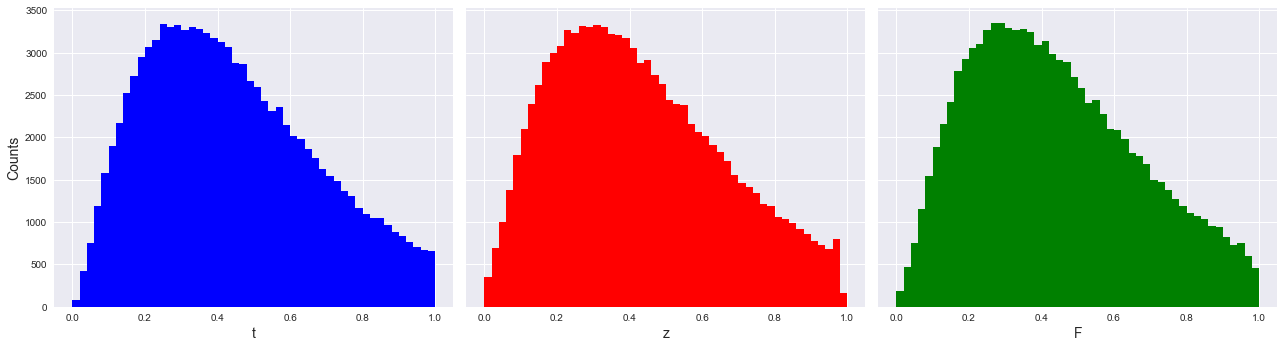

In [51]:
fig, axs = plt.subplots(1,3, figsize=(18,5), sharey=True)
axs = axs.ravel()

axs[0].hist(galaxies['t'], bins=t_bins, color='blue')
axs[1].hist(galaxies['z'], bins=z_bins, color='red')
axs[2].hist(galaxies['F'], bins=t_bins, color='green')

axs[0].set_ylabel('Counts', fontsize=fs)
axs[0].set_xlabel('t', fontsize=fs)
axs[1].set_xlabel('z', fontsize=fs)
axs[2].set_xlabel('F', fontsize=fs)

plt.tight_layout()
plt.show()

### Reproduction of Figure 2

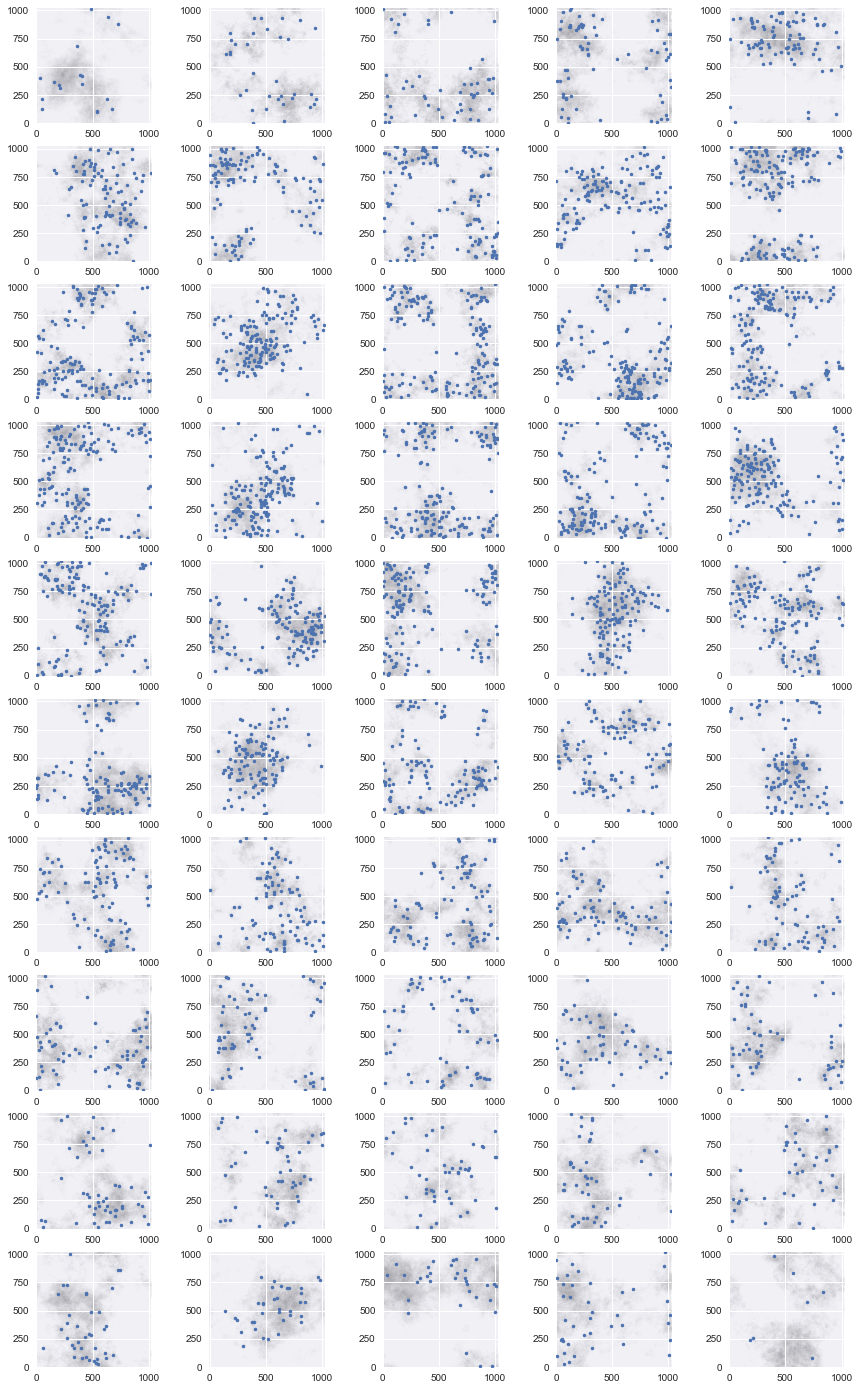

In [62]:
fig, axs = plt.subplots(10,5, figsize=(15,25))
axs = axs.ravel()

unique, counts = np.unique(galaxies['z_bin'], return_counts=True)
## Only plot a random 5% subsample of 
n_subsamples = (counts * 0.05).astype(int)

for i in range(nz):
    select = galaxies['z_bin'] == i
    axs[i].imshow(rho[:,:,i].T, origin='lower', alpha=0.3)
    axs[i].plot(galaxies[select]['theta_x'][:n_subsamples[i]], 
                galaxies[select]['theta_y'][:n_subsamples[i]], '.')

### Section 5.1

#### Now that we've generated our photometric data set, we will use this to reproduce the figures in this section.

The results of the fiducial case use 8 x 10^4 galaxies from the initial simulation. I will be using 79k of these as my photometric sample (for which we know only F, theta), and a random 'spectroscopic' subset of 1k galaxies as my prior (z,t).

In [8]:
n_fiducial = 80000
n_prior = 1000
n_galaxies = n_fiducial - n_prior

In [9]:
## Select a random subset of the 100k galaxies we generated earlier
fiducial_indices = np.arange(N)
rndm_fiducial = np.random.choice(fiducial_indices, size=n_fiducial, replace=False)
fiducial_set = galaxies[rndm_fiducial]


## Select a random subset of 1k galaxies from the fiducial set as our prior
all_indices = np.arange(n_fiducial)
rndm_prior = np.random.choice(all_indices, size=n_prior, replace=False)
rndm_feature = np.isin(all_indices, rndm_prior, invert=True)
prior_data = fiducial_set[rndm_prior]
feature_data = fiducial_set[rndm_feature]

In [446]:
prior_data.write('../data/bernstein_data/prior_data_seed11.fits', format='fits')
feature_data.write('../data/bernstein_data/feature_data_seed11.fits', format='fits')

In [268]:
## Sanity checks
print(len(prior_data), len(feature_data))
print(np.any(np.unique(feature_data['F'], return_counts=True)[1] > 1))

1000 79000
False


In [292]:
## Probably unnecessary...
prior_data.remove_columns(['F', 'theta_x', 'theta_y', 'z_bin'])

### Run the Gibbs sampler

In [9]:
def gibbs_sampler(feature_data, prior_data, posterior, seed, sigma=sig_F, eps=1e-4, size=n_galaxies, n_cycles=2500, save=False):
    
    rng = np.random.RandomState(seed)
    
    z_samples = np.empty((n_cycles, size), dtype=np.float64)
    t_samples = np.empty((n_cycles, size), dtype=np.float64)
    
    ## Initial data
    new_z = prior_data['z']
    new_t = prior_data['t']

    
    for cycle in range(n_cycles):
        
        print('Cycle {} of {}'.format(cycle+1, n_cycles))
    
        ## Calculate probabilities
        h, _, _ = np.histogram2d(new_z, new_t, bins=(z_bins, t_bins))
                    
        h[h == 0] = eps
        alpha = h.flatten()

        ## Generate Dirichlet posterior for probabilities
        dirichlet = scipy.stats.dirichlet.rvs(alpha, random_state=rng, size=1)
        dirichlet = dirichlet.reshape(nz,nt)
        
        ## Sample from posterior
        new_indices = np.empty(size, dtype=int)
        
        if posterior == 'dirichlet':
            probs = dirichlet
            probs /= np.sum(probs)
            new_indices = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=size, random_state=rng)
            new_indices = np.argmax(new_indices, axis=1)
            
        ## Tried doing this way, but sampling from multinomial.rvs takes too much memory
        ## with len(probs.flatten()) = 79k x 50 x 50, so going back to sampling each galaxy
        ## individually.
        ##elif posterior == 'feature':
            ## Verify that z is flat (should shape be (nz,nt) or (nt,nz)?)
            ##probs = scipy.stats.norm.pdf(x=t_mdpt, loc=feature_data['F'].reshape(-1,1), scale=sigma)
            ##probs = np.full((79000,nt,nz), probs[:,:,np.newaxis])
            ##probs /= np.sum(probs)
            ##print(probs.shape)
            ##new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=size, random_state=rng)
            ##new_indices = np.argmax(new_index, axis=1)
    
        elif posterior == 'feature':
            for k in range(size):
                probs = scipy.stats.norm.pdf(x=t_mdpt, loc=feature_data['F'][k], scale=sigma)
                probs = np.full((nz,nt), probs)
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index, axis=1)
        
                    
        elif posterior == 'dirichlet_feature':
            for k in range(size): 
                norm = scipy.stats.norm.pdf(x=t_mdpt, loc=feature_data['F'][k], scale=sigma)
                probs = dirichlet * norm
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
                
        elif posterior == 'all':
            for k in range(size): 
                norm = scipy.stats.norm.pdf(x=t_mdpt, loc=feature_data['F'][k], scale=sigma) 
                probs = dirichlet * norm * rho[feature_data['theta_x'][k], feature_data['theta_y'][k]].reshape(-1,1)
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
                        
        new_iz, new_it = np.unravel_index(new_indices, (nz,nt))
        
        z_samples[cycle] = z_mdpt[new_iz]
        t_samples[cycle] = t_mdpt[new_it]
        
        ## Informative prior (Section 4.1.2) combines counts from previous cycle with the initial data
        new_z = np.concatenate((prior_data['z'].data, z_samples[cycle]), axis=None)
        new_t = np.concatenate((prior_data['t'].data, t_samples[cycle]), axis=None)
    
    if save:
        np.save('z_samples_{}_{}'.format(posterior, seed), z_samples)
        np.save('t_samples_{}_{}'.format(posterior, seed), t_samples)
    
    return(z_samples, t_samples)

Write a function that compares the output from the last cycle of each chain to the original redshift and type distributions:

In [281]:
def compare_distributions(initial_data, sampled_z, sampled_t):
    
    fig, axs = plt.subplots(1,2, figsize=(15,6), sharey=True)
    axs = axs.ravel()

    axs[0].hist(initial_data['z'], bins=z_bins, alpha=0.3, label='Initial data')
    axs[0].hist(sampled_z[-1], bins=z_bins, histtype='step', lw=2, label='Sampled data')
    axs[1].hist(initial_data['t'], bins=t_bins, alpha=0.3, label='Initial data')
    axs[1].hist(sampled_t[-1], bins=t_bins, histtype='step', lw=2, label='Sampled data')
    
    axs[0].set_ylabel('Counts', fontsize=fs)
    axs[0].set_xlabel('z', fontsize=fs)
    axs[1].set_xlabel('t', fontsize=fs)
    
    axs[0].legend(fontsize=fs)
    axs[1].legend(fontsize=fs)
    
    plt.tight_layout()
    plt.show()

In [274]:
z_test, t_test = gibbs_sampler(feature_data, prior_data, posterior='feature', seed=10, n_cycles=1)

Cycle 1 of 1


Sampling with feature-only posterior does indeed give a flat distribution for z:

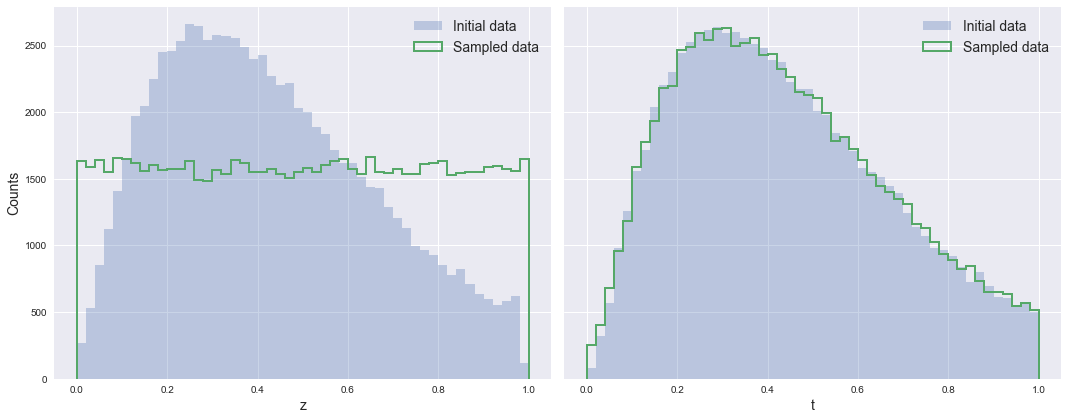

In [280]:
compare_distributions(feature_data, z_test, t_test)

In [282]:
assert len(feature_data) == len(z_test[-1])

Ok, seems to be working so far...need to run for 2500 cycles with 4 different seeds on Cori. Before that try running on for 100 cycles on laptop.

In [360]:
def gibbs_sampler_parallel(q, feature_data, prior_data, posterior, seed, sigma=sig_F, eps=1e-4, size=n_galaxies, n_cycles=100, save=True):
    
    rng = np.random.RandomState(seed)
    
    z_samples = np.empty((n_cycles, size), dtype=np.float64)
    t_samples = np.empty((n_cycles, size), dtype=np.float64)
    
    ## Initial data
    new_z = prior_data['z']
    new_t = prior_data['t']
    
    for cycle in range(n_cycles):
        
        print('Cycle {} of {}'.format(cycle+1, n_cycles))
    
        ## Calculate probabilities
        h, _, _ = np.histogram2d(new_z, new_t, bins=(z_bins, t_bins))
                    
        h[h == 0] = eps
        alpha = h.flatten()

        ## Generate Dirichlet posterior for probabilities
        dirichlet = scipy.stats.dirichlet.rvs(alpha, random_state=rng, size=1)
        dirichlet = dirichlet.reshape(nz,nt)
        
        ## Sample from posterior
        new_indices = np.empty(size, dtype=int)
        
        if posterior == 'dirichlet':
            probs = dirichlet
            probs /= np.sum(probs)
            new_indices = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=size, random_state=rng)
            new_indices = np.argmax(new_indices, axis=1)
            
        elif posterior=='feature':
            for k in range(size): 
                ## Generate probabilities from a normal distribution centered on the feature value 
                ## for that galaxy
                probs = scipy.stats.norm.pdf(x=t_mdpt, loc=feature_data['F'][k], scale=sigma)
                ## Next line is to make sure this has the same dimensions as Dirichlet so that when
                ## we're sampling indices we are sampling from a distribution of the same size 
                ## (i.e. with redshift + type information, not just type information)
                probs = np.full((nz,nt), probs)
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
                    
        elif posterior=='dirichlet_feature':
            for k in range(size): 
                norm = scipy.stats.norm.pdf(x=t_mdpt, loc=feature_data['F'][k], scale=sigma)
                probs = dirichlet * norm
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
                
        elif posterior=='all':
            for k in range(size): 
                norm = scipy.stats.norm.pdf(x=t_mdpt, loc=feature_data['F'][k], scale=sigma) 
                probs = dirichlet * norm * rho[feature_data['theta_x'][k], feature_data['theta_y'][k]].reshape(-1,1)
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
                        
        new_iz, new_it = np.unravel_index(new_indices, (nz,nt))
        
        z_samples[cycle] = z_mdpt[new_iz]
        t_samples[cycle] = t_mdpt[new_it]
        
        ## Informative prior (Section 4.1.2) combines counts from previous cycle with the initial data
        new_z = np.concatenate((prior_data['z'].data, z_samples[cycle]), axis=None)
        new_t = np.concatenate((prior_data['t'].data, t_samples[cycle]), axis=None)
    
    if save:
        np.save('../data/bernstein_data/z_samples_{}_{}_{}'.format(posterior, seed, n_cycles), z_samples)
        np.save('../data/bernstein_data/t_samples_{}_{}_{}'.format(posterior, seed, n_cycles), t_samples)
    
    q.put([z_samples, t_samples])

In [361]:
seeds = [22, 33, 44, 55]

start = time.time()

q = Queue()
p1 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'dirichlet_feature', seeds[0]))
p1.start()
p2 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'dirichlet_feature', seeds[1]))
p2.start()
p3 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'dirichlet_feature', seeds[2]))
p3.start()
p4 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'dirichlet_feature', seeds[3]))
p4.start()
p5 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'all', seeds[0]))
p5.start()
p6 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'all', seeds[1]))
p6.start()
p7 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'all', seeds[2]))
p7.start()
p8 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'all', seeds[3]))
p8.start()

results = []
for i in range(len(seeds)):
    #set block=True to block until we get a result
    results.append(q.get(True))

p1.join()
p2.join()
p3.join()
p4.join()
p5.join()
p6.join()
p7.join()
p8.join()

print('Total time: {}'.format(time.time()-start))

Cycle 1 of 100
Cycle 1 of 100
Cycle 1 of 100
Cycle 1 of 100
Cycle 1 of 100
Cycle 1 of 100
Cycle 1 of 100
Cycle 1 of 100
Cycle 2 of 100
Cycle 2 of 100
Cycle 2 of 100
Cycle 2 of 100
Cycle 2 of 100
Cycle 2 of 100
Cycle 2 of 100
Cycle 2 of 100
Cycle 3 of 100
Cycle 3 of 100
Cycle 3 of 100
Cycle 3 of 100
Cycle 3 of 100
Cycle 3 of 100
Cycle 3 of 100
Cycle 3 of 100
Cycle 4 of 100
Cycle 4 of 100
Cycle 4 of 100
Cycle 4 of 100
Cycle 4 of 100
Cycle 4 of 100
Cycle 4 of 100
Cycle 4 of 100
Cycle 5 of 100
Cycle 5 of 100
Cycle 5 of 100
Cycle 5 of 100
Cycle 5 of 100
Cycle 5 of 100
Cycle 5 of 100
Cycle 5 of 100
Cycle 6 of 100
Cycle 6 of 100
Cycle 6 of 100
Cycle 6 of 100
Cycle 6 of 100
Cycle 6 of 100
Cycle 6 of 100
Cycle 6 of 100
Cycle 7 of 100
Cycle 7 of 100
Cycle 7 of 100
Cycle 7 of 100
Cycle 7 of 100
Cycle 7 of 100
Cycle 7 of 100
Cycle 7 of 100
Cycle 8 of 100
Cycle 8 of 100
Cycle 8 of 100
Cycle 8 of 100
Cycle 8 of 100
Cycle 8 of 100
Cycle 8 of 100
Cycle 8 of 100
Cycle 9 of 100
Cycle 9 of 100
Cycle 9 of

Process Process-28:
Process Process-27:
Process Process-26:
Process Process-25:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/process.py", line 257, in _bootstrap
    util._exit_function()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/process.py", line 257, in _bootstrap
    util._exit_function()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/process.py", line 257, in _bootstrap
    util._exit_function()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 313, in _exit_function
    _run_finalizers()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 313, in _exit_function
    _run_finalizers()


KeyboardInterrupt: 

  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 313, in _exit_function
    _run_finalizers()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/process.py", line 257, in _bootstrap
    util._exit_function()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 313, in _exit_function
    _run_finalizers()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 253, in _run_finalizers
    finalizer()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 253, in _run_finalizers
    finalizer()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 253, in _run_finalizers
    finalizer()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 253, in _run_finalizers
    finalizer()


Combine output from the Gibbs sampler to make violin plots in Figure 3:

In [10]:
def stack_histograms(files, num_bins, bin_edges):
    
    init = np.load(files[0])
    n_cycles = init.shape[0]
    
    stacked = np.empty((len(files), n_cycles, num_bins), dtype=int)
    
    for i, fi in enumerate(files):
        try:
            dat = np.load(fi)
        except ValueError:
            print(i, fi)
        for j in range(n_cycles):
            stacked[i,j], _ = np.histogram(dat[j], bins=bin_edges)
        
    return(np.sum(stacked, axis=0) / len(files))

In [11]:
!ls ../data/bernstein_data/cori/

20190531                          z_samples_all_2.npy
t_samples_all_0.npy               z_samples_all_3.npy
t_samples_all_1.npy               z_samples_dirichlet_0.npy
t_samples_all_2.npy               z_samples_dirichlet_1.npy
t_samples_all_3.npy               z_samples_dirichlet_2.npy
t_samples_dirichlet_0.npy         z_samples_dirichlet_3.npy
t_samples_dirichlet_1.npy         z_samples_dirichlet_feature_0.npy
t_samples_dirichlet_2.npy         z_samples_dirichlet_feature_1.npy
t_samples_dirichlet_3.npy         z_samples_dirichlet_feature_2.npy
t_samples_dirichlet_feature_0.npy z_samples_dirichlet_feature_3.npy
t_samples_dirichlet_feature_1.npy z_samples_feature_0.npy
t_samples_dirichlet_feature_2.npy z_samples_feature_1.npy
t_samples_dirichlet_feature_3.npy z_samples_feature_2.npy
z_samples_all_0.npy               z_samples_feature_3.npy
z_samples_all_1.npy


In [21]:
## The data that are commented out had issues when running on Cori
## d = dirichlet prior, f = feature likelihood, df = dirichlet + feature likelihood, 
## all = dirichlet + feature + clustering
z_d = ['../data/bernstein_data/cori/z_samples_dirichlet_{}.npy'.format(i) for i in range(4)]
#t_d = ['../data/bernstein_data/cori/t_samples_dirichlet_{}.npy'.format(i) for i in range(4)]
z_f = ['../data/bernstein_data/cori/z_samples_feature_{}.npy'.format(i) for i in range(4)]
#t_f = ['../data/bernstein_data/cori/t_samples_feature{}.npy'.format(i) for i in range(4)]
z_df = ['../data/bernstein_data/cori/z_samples_dirichlet_feature_{}.npy'.format(i) for i in range(4)]
t_df = ['../data/bernstein_data/cori/t_samples_dirichlet_feature_{}.npy'.format(i) for i in range(4)]
z_all = ['../data/bernstein_data/cori/z_samples_all_{}.npy'.format(i) for i in range(4)]
t_all = ['../data/bernstein_data/cori/t_samples_all_{}.npy'.format(i) for i in range(4)]

In [17]:
t_df_hist = stack_histograms(t_df, nt, t_bins)
z_df_hist = stack_histograms(z_df, nz, z_bins)
z_all_hist = stack_histograms(z_all, nz, z_bins)
t_all_hist = stack_histograms(t_all, nt, t_bins)

In [52]:
blue = sns.xkcd_rgb["grey blue"]
red = sns.xkcd_rgb["coral"]
green = sns.xkcd_rgb["grey green"]

blue_patch = patches.Patch(color=blue)
red_patch = patches.Patch(color=red)
green_patch = patches.Patch(color=green)

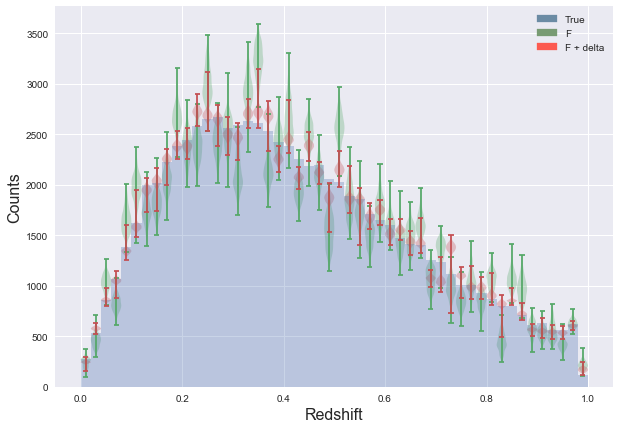

In [26]:
plt.figure(figsize=(10,7))
ax = plt.subplot(111)
plt.hist(feature_data['z'], bins=z_bins, alpha=0.3)
plt.violinplot(z_df_hist, z_mdpt, widths=0.02, points=40)
plt.violinplot(z_all_hist, z_mdpt, widths=0.02, points=40)
plt.xlabel('Redshift', fontsize=16)
plt.ylabel('Counts', fontsize=16)
ax.legend([blue_patch, green_patch, red_patch], ['True', 'F', 'F + delta'])
plt.show()

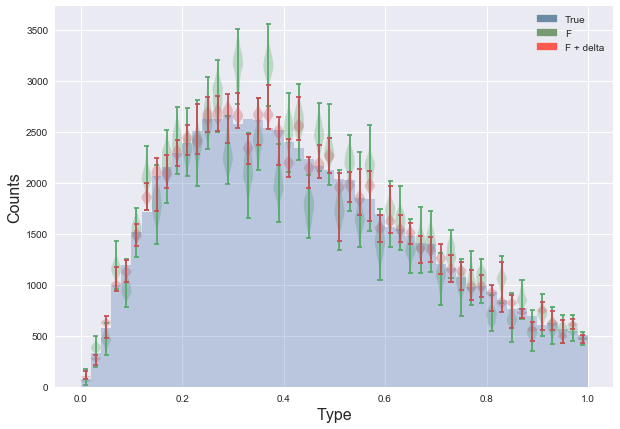

In [27]:
plt.figure(figsize=(10,7))
ax = plt.subplot(111)
plt.hist(feature_data['t'], bins=t_bins, alpha=0.3)
plt.violinplot(t_df_hist, t_mdpt, widths=0.02, points=40)
plt.violinplot(t_all_hist, t_mdpt, widths=0.02, points=40)
plt.xlabel('Type', fontsize=16)
plt.ylabel('Counts', fontsize=16)
ax.legend([blue_patch, green_patch, red_patch], ['True', 'F', 'F + delta'])
plt.show()

### $\Delta$z metric


Make a histogram of the difference between the recovered distribution of each sampled redshift histogram and the true redshift distribution (reproducing Figure 4). Each chain (represented as a single .npy file) contains 2500 samples, and each sample contains 79000 galaxies. Each posterior type (i.e. dirichlet, dirichlet + feature, etc.) therefore has 4 chains x 2500 = 10000 samples each.

In [28]:
z_d_0 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_0.npy')
z_d_1 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_1.npy')
z_d_2 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_2.npy')
z_d_3 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_3.npy')

In [29]:
z_df_0 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_feature_0.npy')
z_df_1 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_feature_1.npy')
z_df_2 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_feature_2.npy')
z_df_3 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_feature_3.npy')

In [30]:
z_all_0 = np.load('../data/bernstein_data/cori/z_samples_all_0.npy')
z_all_1 = np.load('../data/bernstein_data/cori/z_samples_all_1.npy')
z_all_2 = np.load('../data/bernstein_data/cori/z_samples_all_2.npy')
z_all_3 = np.load('../data/bernstein_data/cori/z_samples_all_3.npy')

In [31]:
print(z_d_0.shape)
print(z_df_0.shape)
print(z_all_0.shape)

(2500, 79000)
(2500, 79000)
(2500, 79000)


In [33]:
z_d_concat = np.concatenate((z_d_0, z_d_1, z_d_2, z_d_3), axis=0)
z_df_concat = np.concatenate((z_df_0, z_df_1, z_df_2, z_df_3), axis=0)
z_all_concat = np.concatenate((z_all_0, z_all_1, z_all_2, z_all_3), axis=0)

In [36]:
del_z_d = np.mean(z_d_concat, axis=1) - np.mean(feature_data['z'])
del_z_df = np.mean(z_df_concat, axis=1) - np.mean(feature_data['z'])
del_z_all = np.mean(z_all_concat, axis=1) - np.mean(feature_data['z'])

In [120]:
d_mu = np.mean(del_z_d)
df_mu = np.mean(del_z_df)
all_mu = np.mean(del_z_all)

In [124]:
fs = 14

In [197]:
bin_edges = np.linspace(-0.008, 0.0045, 30)

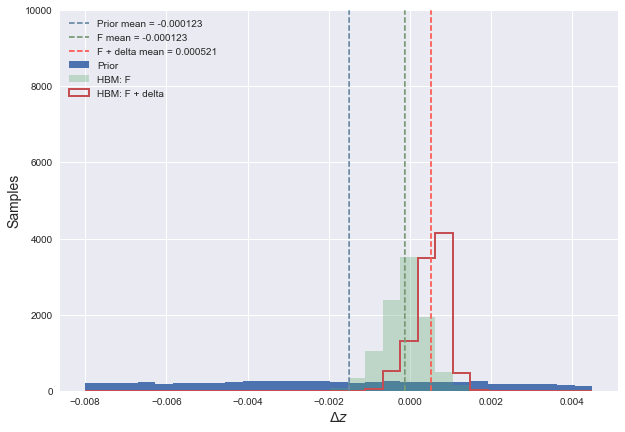

In [199]:
ylim = 10000
## 10000 histograms
plt.figure(figsize=(10,7))
plt.hist(del_z_d, bins=bin_edges, range=(-0.008,0.005), label='Prior')
plt.hist(del_z_df, bins=bin_edges, range=(-0.008,0.005), label='HBM: F', alpha=0.3)
plt.hist(del_z_all, bins=bin_edges, range=(-0.008,0.005), histtype='step', lw=2, label='HBM: F + delta')
plt.plot(np.full(ylim, d_mu), np.arange(0,ylim), c=blue, ls='--', label='Prior mean = {:2f}'.format(df_mu))
plt.plot(np.full(ylim, df_mu), np.arange(0,ylim), c=green, ls='--', label='F mean = {:2f}'.format(df_mu))
plt.plot(np.full(ylim, all_mu), np.arange(0,ylim), c=red, ls='--', label='F + delta mean = {:2f}'.format(all_mu))
plt.xlabel('$\Delta z$', fontsize=fs)
plt.ylabel('Samples', fontsize=fs)
plt.ylim(0,ylim)
plt.legend(loc=2)
plt.show()

Next: separate low redshift (z < 0.5) samples.

In [200]:
## Select all z < 0.5 from both z_all_concat and feature_data
z_all_lowz = np.where(z_all_concat < 0.5, z_all_concat, np.nan)
feature_data_lowz = np.where(feature_data['z'] < 0.5, feature_data['z'], np.nan)

In [201]:
del_zall_lowz = np.nanmean(z_all_lowz, axis=1) - np.nanmean(feature_data_lowz)

In [202]:
lowz_mu = np.mean(del_zall_lowz)

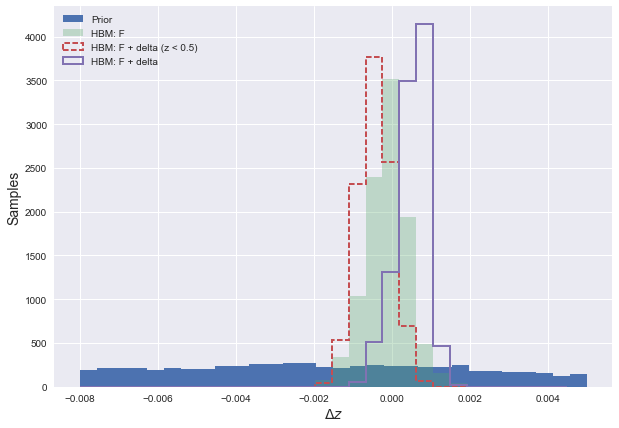

In [204]:
plt.figure(figsize=(10,7))
plt.hist(del_z_d, bins=30, range=(-0.008,0.005), label='Prior')
plt.hist(del_z_df, bins=bin_edges, range=(-0.008,0.005), label='HBM: F', alpha=0.3)
plt.hist(del_zall_lowz, bins=bin_edges, range=(-0.008,0.005), histtype='step', ls='--', lw=2, label='HBM: F + delta (z < 0.5)')
plt.hist(del_z_all, bins=bin_edges, range=(-0.008,0.005), histtype='step', lw=2, label='HBM: F + delta')
plt.xlabel('$\Delta z$', fontsize=fs)
plt.ylabel('Samples', fontsize=fs)
plt.legend(loc=2)
plt.show()

In [206]:
z_all_highz = np.where(z_all_concat > 0.5, z_all_concat, np.nan)
feature_data_highz = np.where(feature_data['z'] > 0.5, feature_data['z'], np.nan)

In [209]:
highz = z_all_concat[z_all_concat >= 0.5]

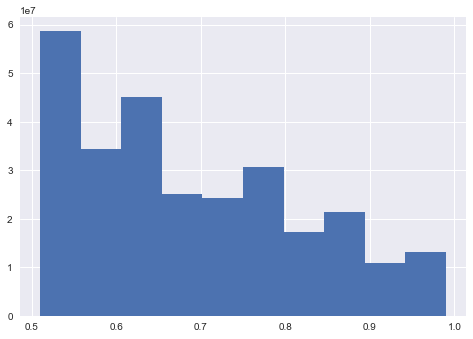

In [213]:
plt.hist(highz)
#plt.hist(feature_data['z'][feature_data['z'] >= 0.5])
plt.show()

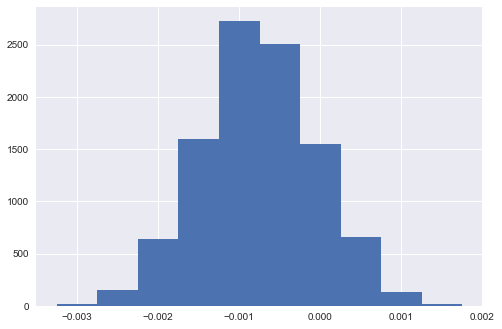

In [221]:
plt.hist(np.nanmean(z_all_highz, axis=1) - np.nanmean(feature_data_highz))
plt.show()

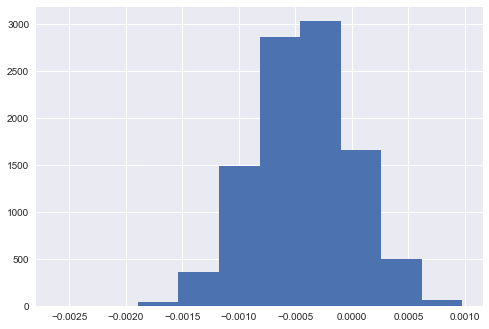

In [222]:
plt.hist(del_zall_lowz)
plt.show()

In [217]:
np.nanmean(feature_data_highz)

0.6875567435702117

In [216]:
np.mean(highz)

0.6867943191126418

In [215]:
np.mean(feature_data['z'][feature_data['z'] >= 0.5])

0.6875567435702118

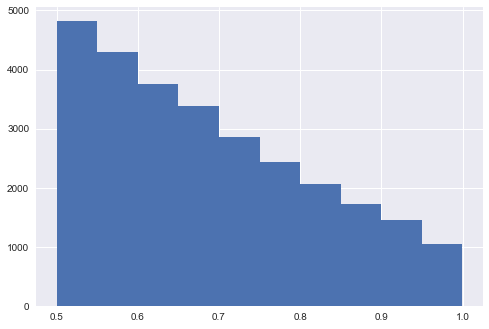

In [223]:
plt.hist(feature_data['z'][feature_data['z'] >= 0.5])
plt.show()

## Scratch work

### Let's compare the output from the last cycle of each chain to the original redshift and type distributions:

In [77]:
def compare_distributions(initial_data, sampled_z, sampled_t):
    
    fig, axs = plt.subplots(1,2, figsize=(15,6), sharey=True)
    axs = axs.ravel()

    axs[0].hist(initial_data['z'], bins=z_bins, alpha=0.3, label='Initial data')
    axs[0].hist(sampled_z[-1], bins=z_bins, histtype='step', lw=2, label='Sampled data')
    axs[1].hist(initial_data['t'], bins=t_bins, alpha=0.3, label='Initial data')
    axs[1].hist(sampled_t[-1], bins=t_bins, histtype='step', lw=2, label='Sampled data')
    
    axs[0].set_ylabel('Counts', fontsize=fs)
    axs[0].set_xlabel('z', fontsize=fs)
    axs[1].set_xlabel('t', fontsize=fs)
    
    axs[0].legend(fontsize=fs)
    axs[1].legend(fontsize=fs)
    
    plt.tight_layout()
    plt.show()

### Case 1) Use the entire initial data set as our prior

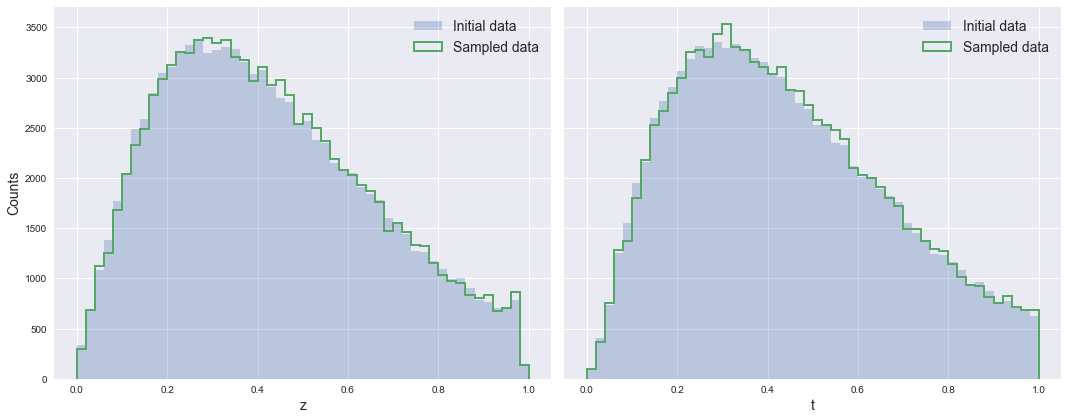

In [78]:
compare_distributions(galaxies, z_dirichlet, t_dirichlet)

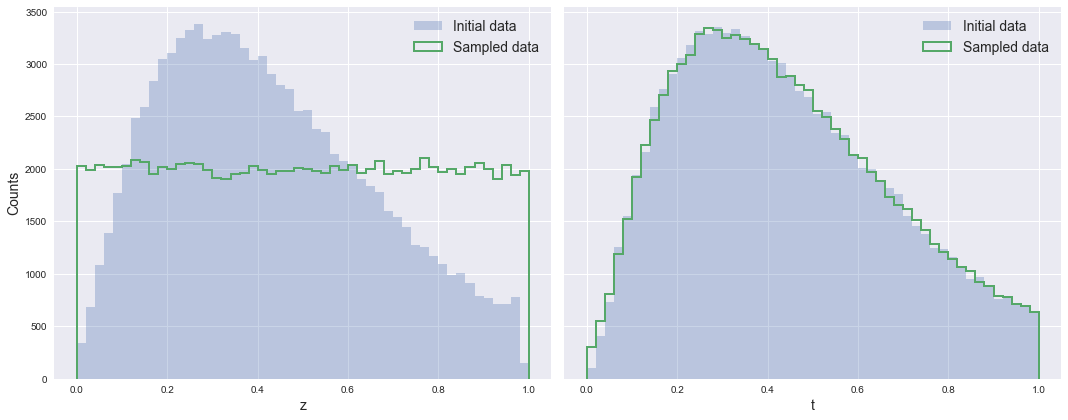

In [79]:
compare_distributions(galaxies, z_feature, t_feature)

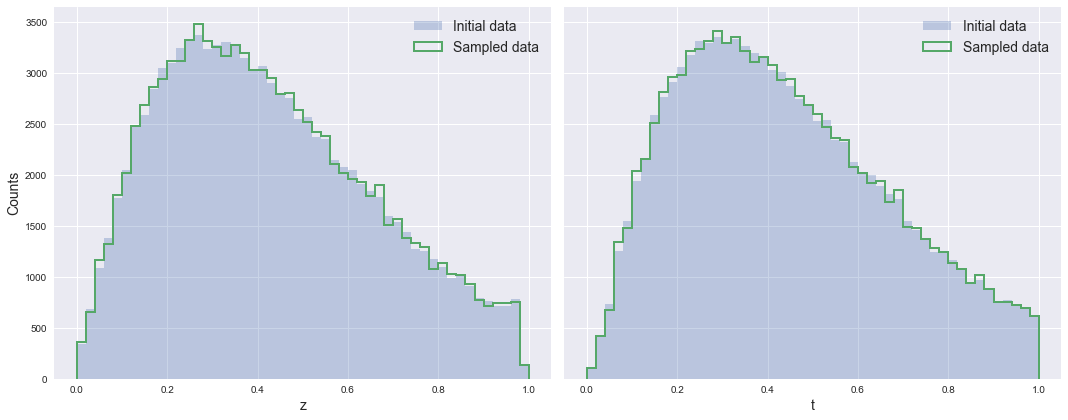

In [80]:
compare_distributions(galaxies, z_dirichlet_feature, t_dirichlet_feature)

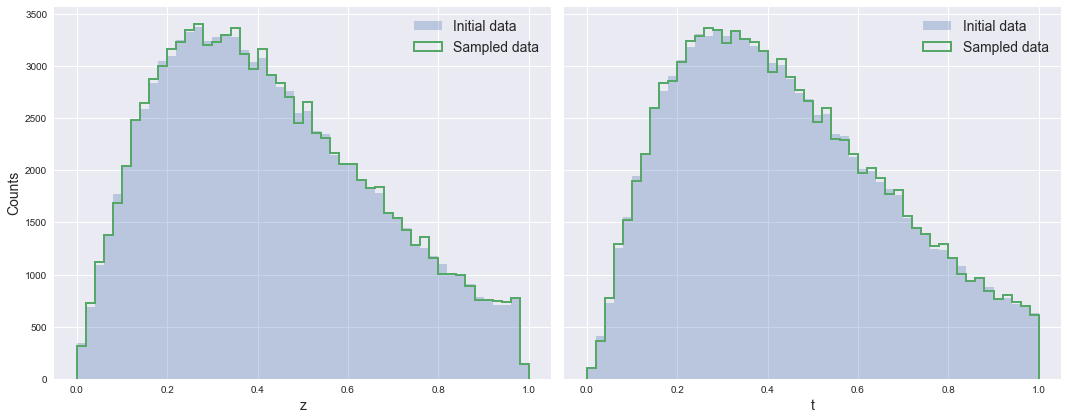

In [81]:
compare_distributions(galaxies, z_all, t_all)

### Case 2) Use one third of the entire initial data set as our prior

In [97]:
n_cycles = 20

In [88]:
## Dirichlet only
z_dirichlet, t_dirichlet = gibbs_sampler(initial_data=galaxies, posterior='dirichlet', 
                                         seed=walker_seed, fraction=33333, n_cycles=n_cycles)

Cycle 1 of 5
Cycle 2 of 5
Cycle 3 of 5
Cycle 4 of 5
Cycle 5 of 5


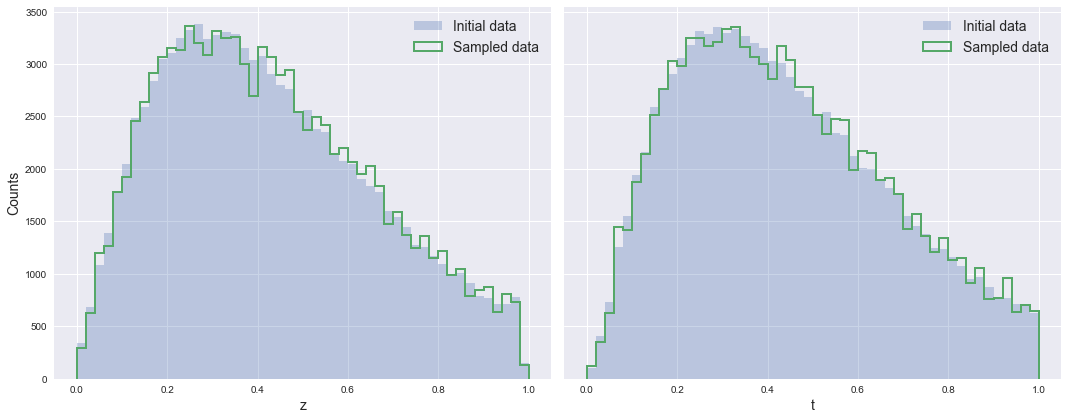

In [89]:
compare_distributions(galaxies, z_dirichlet, t_dirichlet)

In [90]:
## Feature likelihood only
z_feature, t_feature = gibbs_sampler(initial_data=galaxies, posterior='feature', 
                                         seed=walker_seed, n_cycles=n_cycles)

Cycle 1 of 5
Cycle 2 of 5
Cycle 3 of 5
Cycle 4 of 5
Cycle 5 of 5


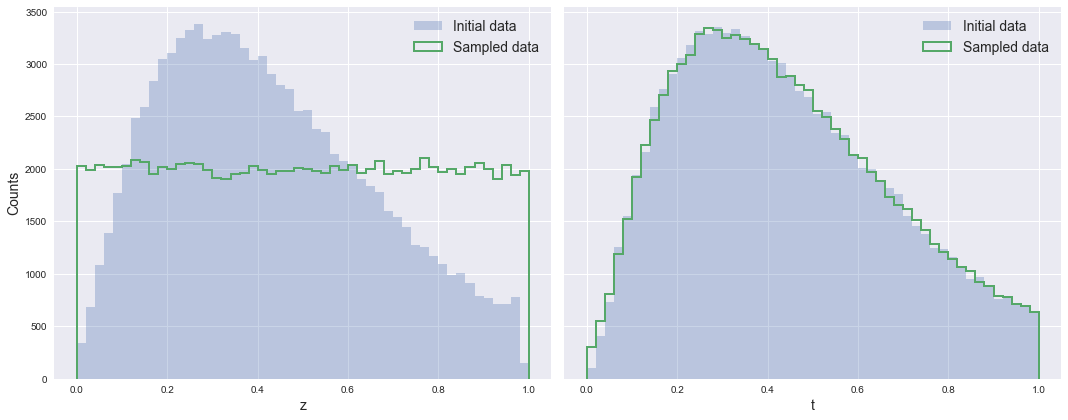

In [91]:
compare_distributions(galaxies, z_feature, t_feature)

In [98]:
## Dirichlet + feature likelihood
z_dirichlet_feature, t_dirichlet_feature = gibbs_sampler(initial_data=galaxies, posterior='dirichlet_feature', 
                                         seed=walker_seed, n_cycles=n_cycles)

Cycle 1 of 20
Cycle 2 of 20
Cycle 3 of 20
Cycle 4 of 20
Cycle 5 of 20
Cycle 6 of 20
Cycle 7 of 20
Cycle 8 of 20
Cycle 9 of 20
Cycle 10 of 20
Cycle 11 of 20
Cycle 12 of 20
Cycle 13 of 20
Cycle 14 of 20
Cycle 15 of 20
Cycle 16 of 20
Cycle 17 of 20
Cycle 18 of 20
Cycle 19 of 20
Cycle 20 of 20


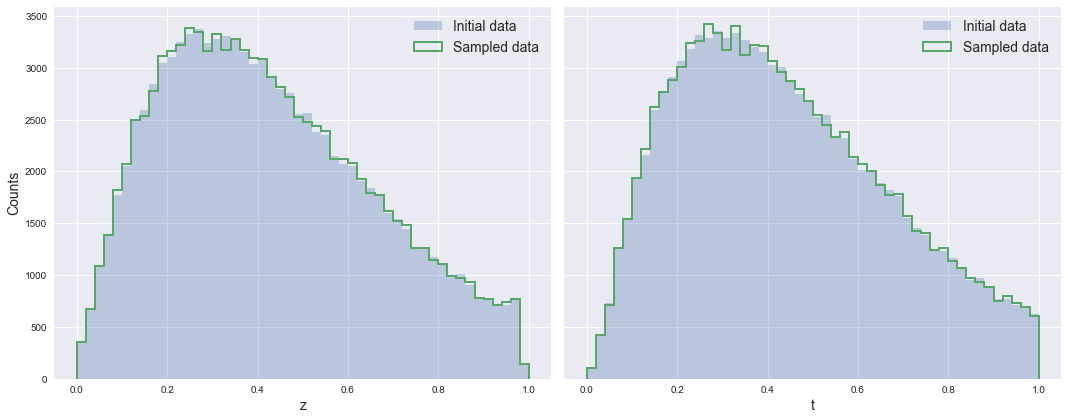

In [99]:
compare_distributions(galaxies, z_dirichlet_feature, t_dirichlet_feature)

In [100]:
## Dirichlet + feature likelihood + delta field
z_all, t_all = gibbs_sampler(initial_data=galaxies, posterior='all', 
                                         seed=walker_seed, n_cycles=n_cycles)

Cycle 1 of 20
Cycle 2 of 20
Cycle 3 of 20
Cycle 4 of 20
Cycle 5 of 20
Cycle 6 of 20
Cycle 7 of 20
Cycle 8 of 20
Cycle 9 of 20
Cycle 10 of 20
Cycle 11 of 20
Cycle 12 of 20
Cycle 13 of 20
Cycle 14 of 20
Cycle 15 of 20
Cycle 16 of 20
Cycle 17 of 20
Cycle 18 of 20
Cycle 19 of 20
Cycle 20 of 20


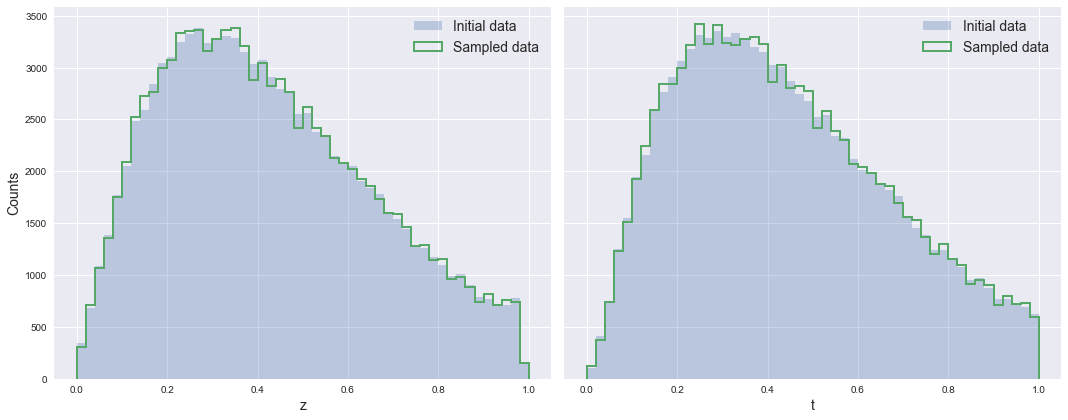

In [101]:
compare_distributions(galaxies, z_all, t_all)